<a href="https://colab.research.google.com/github/thakerpragnesh/DeepLearning/blob/master/05_VGGNetPruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code will help you to load google dive in the jupiter notebook and help to access the dataset stored in the drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Following cell will import basic numeric and ploting librrary

In [ ]:
#import basic library for some basic function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import cv2

Following Cell facilitate to read files from drive and and help to read dataset

In [ ]:
# import library to perform file operation
import os #use to access the files 
import tarfile # use to extract dataset from zip files
import sys
import zipfile

Torch Library provides facilities to create networl architechture and write farword and backwor phase od neural network

In [ ]:
#import torch library to build neural network
import torch  # Elementory function of tensor is define in torch package
import torch.nn as nn # Several layer architectur is define here
import torch.nn.functional as F # loss function and activation function


Computer vision is one of the most important application and thus lots od deplopment in the and torch.vision provides many facilities that can be use to imporve model such as data augmentation, reading data batchwise, suffling data before each epoch and many more


In [ ]:
# import torch library related to data processing
import torchvision # provides facilities to access image dataset
from torchvision.datasets.utils import download_url 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import datasets, models, transforms

#Data Prepration 1

Based on the image size of the dataset choose apropriate values of the color channel and Image Size

Here we can define path to a folder where we can keep all the dataset. In the following we are using the zip files. Originally dataset should be in the following format DataSetName is parent folder and it should contain train and test folder. train and test folder should contain folder for each category and images of respective category should be in the respective category folder

In [ ]:
datafile = 'cifar10'
path = '/content/gdrive/My Drive/Dataset/'
fullpath = path+datafile+'.zip'
zip_ref = zipfile.ZipFile(fullpath, 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Choose an apropriate batch size that can be loaded in the current enviroment without crashing and also do not choose too big batch even if dataset is small because it leads to very few updates per epoch

In [ ]:
bs = 128
ImageSize = 224

Data Augmentaion generally help in reducing overfitting error during trainng process and thus we are performing randon horizontal flip and random crop during training but during validation as no training happens we dont perform data augmentation


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(ImageSize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/tmp/cifar10'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Look inside the single batch of dataset images we are going to train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


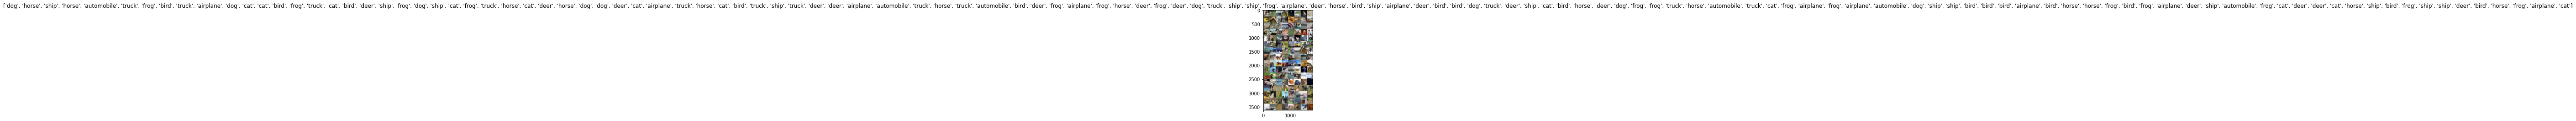

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Check if Cuda GPU is available

In [ ]:
#check for CUDA enabled GPU card
def getDeviceType():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


device = getDeviceType()
print(device)

cpu


#Training Process
Below code will work as a base function and provide all the important function like compute loss, accuracy and print result in a perticular formate afte each epoch. Funvtion are as follow
1. Accuracy : Computer accuracy in evalutaion mode of pytorch on given dataset for given model
2. compute_batch_loss : Compute batch loss and append the loss in the list of batch loss.
3. compute_batch_loss_acc : Compute batch loss, batch accuracy and append the loss in the list of batch loss.
4. accumulate_batch_loss_acc: Accumulate loss from the list of batch and acccuraly loss.
5. Epoch end to print the output after every epoch in proper format


In [ ]:
def accuracy(outputs, labels):
# compute accuracy = total correct prediction / total number f ele

    # torch.max(output, dim) will return max value and corresponding index, 
    # Here we are intersted only on index value as it indicate class
    _, preds = torch.max(outputs, dim=1) # get the prediction vector
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Compute loss of the given batch and return it
def compute_batch_loss(newmodel, batch_X,batch_y):
  images = batch_X.to(device)
  labels = batch_y.to(device)
  out = newmodel(images)                  # Generate predictions
  loss = F.cross_entropy(out, labels) # Calculate loss
  return loss

# Computes loss and accuracy of the given batch(Used in validation)
def compute_batch_loss_acc(newmodel, batch_X,batch_y):
    images = batch_X.to(device)
    labels = batch_y.to(device)
    out = newmodel(images)                    # Generate predictionsin_features=4096
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}

# At the end of epoch accumulate all batch loss and batch accueacy    
def accumulate_batch_loss_acc(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
  # Print in given format 
  # Epoch [0], last_lr: 0.00278, train_loss: 1.2862, val_loss: 1.2110, val_acc: 0.6135
  strResult = "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
      epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc'])
  print(strResult)
  #print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
  #   epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

#Define Archietecture

In [ ]:
def conv_block(in_channels, out_channels, pool=False, kernalSize =3, padd = 1 ):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernalSize, padding=padd), 
              nn.BatchNorm2d(out_channels), # Layerwise Noramlizarion
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2)) 
    return nn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = nn.Sequential(
        nn.Dropout(p=0.6),
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),
        nn.ReLU()
    )
    return layer

In [ ]:
class VGG_Net_16(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        
        super().__init__()
        
        # VGG_BLOCK_1(03,64)    -> Input(3,64x64) -> Output(64,32x32)
        self.conv11 = conv_block(in_channels, 64,pool=False)
        self.conv12 = conv_block(64, 64,pool=True) #112x112

        # VGG_BLOCK_2(64,128)   -> Input(64,32x32) -> Output(128,16x16)
        self.conv21 = conv_block(64,128,pool=False)
        self.conv22 = conv_block(128, 128, pool=True) #56x56                             
        
        # VGG_BLOCK_3(128,128) -> Input(128,16x16) -> Output(128,16x16)
        self.conv31 = conv_block(128,256,pool=False)
        self.conv32 = conv_block(256, 256, pool=False)  #28x28
        self.conv33 = conv_block(256, 256, pool=True)
        
        # VGG_BLOCK_4(256,512)  -> Input(256,8x8) -> Output(512x4x4)
        self.conv41 = conv_block(256, 512, pool=False)                              
        self.conv42 = conv_block(512, 512, pool=False)
        self.conv43 = conv_block(512, 512, pool=True)  #14x14

        # VGG_BLOCK_5(512,512) -> Input(512x4x4) -> Output(512x4x4)
        self.conv51 = conv_block(512, 512, pool=False)                              
        self.conv52 = conv_block(512, 512, pool=False)
        self.conv53 = conv_block(512, 512, pool=True)  #7x7

          
        # Classifier Part Of VGG_Net
        self.FC1 = vgg_fc_layer(7*7*512, 4096)
        self.FC2 = vgg_fc_layer(4096, 4096)
        self.output = vgg_fc_layer(7*7*512, 4096)
    
    def forward(self, xb):
        out = self.conv11(xb)
        out = self.conv12(out)
        
        out = self.conv21(out)
        out = self.conv22(out)

        out = self.conv31(out)
        out = self.conv32(out)
        out = self.conv33(out)

        out = self.conv41(out)
        out = self.conv42(out)
        out = self.conv43(out)

        out = self.conv51(out)
        out = self.conv52(out)
        features = self.conv53(out)

        out = features.view(out.size(0), -1)  # Flatten the layer
        return out

In [ ]:
MyNewModel = VGG_Net_16(3,10)
print(MyNewModel)

## Define Training 
Here we will evalute our model after each epoch on validation dataset using evalute method
get_lr method returnd last learning rate used in the training
Here we are using one fit cycle method in which we specify the max learning rate and learning rate start from 1/10th value of max_lr and slowly increases the value to max_lr for 40% of updates then decreases to its initial value for 40% updates and then further decreases to 1/100th of max_lr value to perform final fine tuning.

In [ ]:
@torch.no_grad()
# evalute model on validation dataset
def evaluate(model, data_loader):
    model.eval()
    with torch.no_grad():
      for batch_X, batch_y in data_loader:
        outputs = [compute_batch_loss_acc(model,batch_X,batch_y)]
      return accumulate_batch_loss_acc(outputs)

# Use special scheduler to change the value of learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# epoch=8, max_lr=.01, weight_decay(L2-Regu parametr)=.0001,opt_func=Adam


def fit_one_cycle(ModelName,epochs, max_lr, model, 
                  weight_decay=0, L1=0,grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer here we will use one cycle scheduler with max learning
    # rate given by max_lr, default optimizer is SGD but we will use ADAM, and 
    # L2 Regularization using weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(dataloaders['train']))
    
    print("Training Starts")
    with open("/content/gdrive/My Drive/data/ConvModel.log","a") as f:
      for epoch in range(epochs):
          # Training Phase 
          model.train()  #######################
          train_losses = []
          lrs = []
          #for batch in train_loader:
          for batch_X, batch_y in dataloaders['train']:
              
              # computer the training loss of current batch
              loss = compute_batch_loss(model,batch_X,batch_y)
              
              l1_crit = nn.L1Loss()
              reg_loss = 0
              for param in model.parameters():
                reg_loss += l1_crit(param,target=torch.zeros_like(param))

              loss += L1*reg_loss 
              train_losses.append(loss)
              loss.backward() # compute the gradient of all weights
              
              # Clip the gradient value to maximum allowed grad_clip value
              if grad_clip: 
                  nn.utils.clip_grad_value_(model.parameters(), grad_clip)
              
              optimizer.step() # Updates weights 
              # pytorch by default accumulate grade history and if we dont want it
              # we should make all previous grade value equals to zero
              optimizer.zero_grad() 
              
              # Record & update learning rate
              lrs.append(get_lr(optimizer))
              sched.step() # Update the learning rate
          
          # Compute Validation Loss and Valodation Accuracy
          result = evaluate(model, dataloaders['test'])

          # Compute Train Loss of whole epoch i.e mean of loss of batch 
          result['train_loss'] = torch.stack(train_losses).mean().item()

          # Observe how learning rate is change by schedular
          result['lrs'] = lrs

          # print the observation of each epoch in a proper format
          epoch_end(epoch, result) 
          strResult = "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc'])
          #f.write(f"{ModelName}-{strResult}\n")
          history.append(result) # append tupple result with val_acc, vall_loss, and trin_loss
        
    return history

Define the function that help is evaluating the model such as 
1. acuracy vs eopch to see that whether performance is improving or not during training, 
2. model loss vs epoch to see the loos value improvment during each epoch and 
3. learning rate plot to see how learning rate changes during each updates

In [ ]:
# Plot Validation accuracy Over Epoch
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

# Plot training and validation loss to check for overfitting and underfitting
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# plot the learning rate values over each batch
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

we can download pretrain model and perform fine tuning on the model with fix feature extracter using the following

In [ ]:
'''
newModel = torchvision.models.vgg16(pretrained=True)

for param in newModel.parameters():
    param.requires_grad = False

#print(newModel)

#Need to change the below code if we choose different model
print(newModel.classifier[6])
num_ftrs = newModel.classifier[6].in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
newModel.classifier[6] = nn.Linear(num_ftrs, 10)

newModel = newModel.to(device)
'''
##################### Create ResNet 18 ############################

'''
newModel = torchvision.models.resnet18(pretrained=True)
print(newModel.fc)

for param in newModel.parameters():
    param.requires_grad = False

#print(newModel)

#Need to change the below code if we choose different model
num_ftrs = newModel.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
newModel.fc = nn.Linear(num_ftrs, 10)

newModel = newModel.to(device)
print(newModel.fc)
print(newModel)
'''

PATH ='/content/gdrive/MyDrive/Model/cifar10/VGG16IntelICV1'
if device== torch.device('cpu'):
  newModel = torch.load(PATH, map_location=torch.device('cpu'))
else:
  newModel = torch.load(PATH)

count=0
# Need to change the following loop for dofferent model
for param in newModel.parameters():
    print(param.shape)
    if count in (26,28,30):
      param.requires_grad=True
      print(param.requires_grad)
    else:
      param.requires_grad=False
      print(param.requires_grad)
    count +=1

In [ ]:
for param in newModel.parameters():
  MyNewModel.conv11.state_dict()

TypeError: ignored

During the next itteration if we had a better model stored in drive we can load model and continue training by learning parameter of all dense layer

In [ ]:
PATH ='/content/gdrive/MyDrive/Model/cifar10/VGG16IntelICV1'
if device== torch.device('cpu'):
  newModel = torch.load(PATH, map_location=torch.device('cpu'))
else:
  newModel = torch.load(PATH)

count=0
# Need to change the following loop for dofferent model
for param in newModel.parameters():
    print(param.shape)
    if count in (26,28,30):
      param.requires_grad=True
      #print(param.requires_grad)
    else:
      param.requires_grad=False
      #print(param.requires_grad)
    count +=1

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([10, 4096])
torch.Size([10])


Initialise all the hyper meter required for training such as learning rate that control the step size, gradient clipping value that limits the maximum value of grads, L2 regularization using weight decay value, L1 regularization using L1 value and then choose apropriate optimization funtion for training.

In [ ]:
historyfull = []

In [ ]:
historylast = []
epochs = 10
# We are using one cycle fit function in which learning rate start with 1/10th 
# of selected maximum learning rate and increase learning rate from min to max
# in 1st phase and then decrease from max to min in 2nd phase
max_lr = 1e-3
grad_clip = 0.1 # Maximum allowed value of grad: grad = min(grad,0.01)
# weight decay is a constant multiplier for L2 regularization
weight_decay = 1e-4
L1 = 1e-4
# Choosing Adma optimizer as try to implement SGD+Momentum+Adaptive Learining
opt_func = torch.optim.Adam
MODEL_NAME = f"VGG_Net-MLR-{max_lr}-GC{grad_clip}-WD-{weight_decay}-L1-{L1}"

Start the training using one fit cycle algorithms where learning rate start with one tenth of provided max_lr and then increase it value till that point and then decrease onword and for last few epoch learning rate furthe decrease

Pass the hyperparameter for training of the model and start training process for set number of epcoh

In [ ]:
%%time
historylast += fit_one_cycle(MODEL_NAME,epochs, max_lr, newModel,  
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, L1=L1,
                             opt_func=opt_func)

Training Starts
Epoch [0], last_lr: 0.00028, train_loss: 1.0047, val_loss: 0.1845, val_acc: 0.8750
Epoch [1], last_lr: 0.00076, train_loss: 1.0766, val_loss: 0.2738, val_acc: 0.8750
Epoch [2], last_lr: 0.00100, train_loss: 1.1264, val_loss: 0.6889, val_acc: 0.8125
Epoch [3], last_lr: 0.00095, train_loss: 1.1060, val_loss: 0.9867, val_acc: 0.6250
Epoch [4], last_lr: 0.00081, train_loss: 1.0431, val_loss: 0.6005, val_acc: 0.8750
Epoch [5], last_lr: 0.00061, train_loss: 0.9916, val_loss: 0.3725, val_acc: 0.9375
Epoch [6], last_lr: 0.00039, train_loss: 0.9179, val_loss: 0.4965, val_acc: 0.9375
Epoch [7], last_lr: 0.00019, train_loss: 0.8635, val_loss: 0.4496, val_acc: 0.8750
Epoch [8], last_lr: 0.00005, train_loss: 0.8243, val_loss: 0.1414, val_acc: 0.9375
Epoch [9], last_lr: 0.00000, train_loss: 0.8031, val_loss: 0.4485, val_acc: 0.8125
CPU times: user 49min 52s, sys: 1min 26s, total: 51min 19s
Wall time: 53min 40s


In [ ]:
for item in historylast:
  historyfull.append(item)

Evalute model for accuracy for last training run 

Accuracy in last run


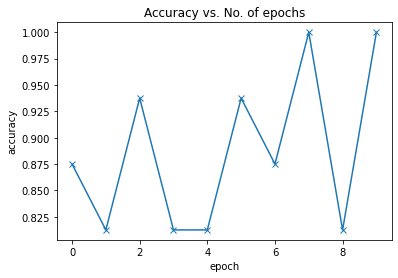

In [ ]:
print("Accuracy in last run")
plot_accuracies(historylast)

Evalute Models for whole training process for accuracy


Accuracy is all run


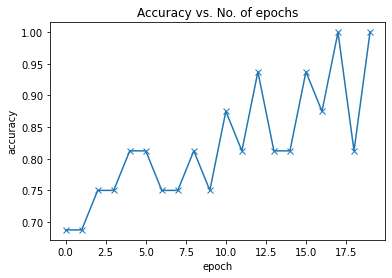

In [ ]:
print("Accuracy is all run")
plot_accuracies(historyfull)

Evalute last run for loss

Loss of last run


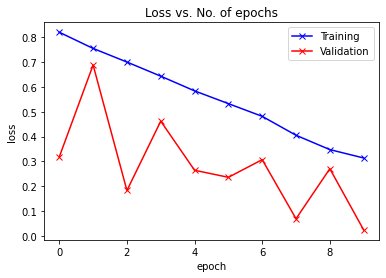

In [ ]:
print("Loss of last run")
plot_losses(historylast)

Evalute full training process for loss value

Loss in All run


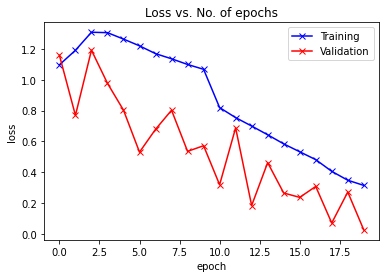

In [ ]:
print("Loss in All run")
plot_losses(historyfull)

See how the learning rate changedin process

Learning rate of all run


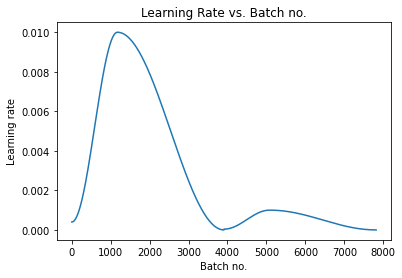

In [ ]:
print("Learning rate of all run")
plot_lrs(historyfull)

Print validation accuracy for all epoch of last run

In [ ]:
accuracies = [x['val_acc']*100 for x in historylast]
accuracies = ["%.2f" % v for v in accuracies]
print(accuracies)

['87.50', '81.25', '93.75', '81.25', '81.25', '93.75', '87.50', '100.00', '81.25', '100.00']


Define method to compute accuracy for a given model on given dataset

In [ ]:
def accuraciesTotal(newModel, data_loader):
  with torch.no_grad():
    acc = []
    for batch in data_loader:
      images, label = batch
      images, labels = batch[0].to(device), batch[1].to(device)
      out = newModel(images)
      acc.append(accuracy(out, labels))
    return torch.mean(torch.stack(acc))

evalute final accuracy of test and train dataset

In [ ]:
#trainacc = accuraciesTotal(newModel,dataloaders['train'])
testacc = accuraciesTotal(newModel,dataloaders['test'])
#print("Train Acc :" + str(trainacc) + "\nTest  Acc :" +str(testacc))
print(testacc)

tensor(0.8257)


Save the model if we feel we have made some improvement in the model


In [ ]:
PATH = "/content/gdrive/My Drive/Model/cifar10/ResNet18_Cifar_CV1"
torch.save(newModel, PATH)

# Below code shows basic unstructure pruning methods provided by the pytorch. Here if we want to apply custom pruning then we need to write our own compute_mask function 

In [ ]:
#import library to facilitate pruning
import torch.nn.utils.prune as prune
import time

In [ ]:
modules = newModel.features
print(modules)

In [ ]:
Module = []
for i in (0,2,5,7,10,12,14,17,19,21,24,26,28):
  Module.append(newModel.features[i])

for i in range(len(Module)):
  print(Module[i].parameters)

<bound method Module.parameters of Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method Module.parameters of Conv2d(512, 512, kernel_size=(3, 3)

In [ ]:
'''
Module = [model.conv11[0], model.conv12[0],
          model.conv21[0],model.conv22[0],
          model.conv31[0], model.conv32[0], model.conv33[0],
          model.conv41[0], model.conv42[0], model.conv43[0],
          model.conv51[0], model.conv52[0], model.conv53[0]
]
print(Module)
'''

#for i in range(len(Module)):
#  print(Module[i])

pr = [.1,.1,.1,.1,.2,.2,.2,.25,.25,.25,.25,.25,.25]
for i in range(len(Module)):
  prune.ln_structured(Module[i], name="weight", amount=pr[i], n=1, dim=0)

import torch.nn.utils.prune as prune
parameters_to_prune = (Module)
'''
    (model.conv11[0], 'weight'),
    (model.conv12[0], 'weight'),

    (model.conv21[0], 'weight'),
    (model.conv22[0], 'weight'),

    (model.conv31[0], 'weight'),
    (model.conv32[0], 'weight'),
    (model.conv33[0], 'weight'),

    (model.conv41[0], 'weight'),
    (model.conv42[0], 'weight'),
    (model.conv43[0], 'weight'),

    (model.conv51[0], 'weight'),
    (model.conv52[0], 'weight'),
    (model.conv53[0], 'weight'),
)
'''
print(parameters_to_prune)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


In [ ]:
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2
)

TypeError: ignored

In [ ]:
print(parameters_to_prune)

In [ ]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv11[0].weight == 0))
        / float(model.conv11[0].weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv12[0].weight == 0))
        / float(model.conv12[0].weight.nelement())
    )
)

print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv21[0].weight == 0))
        / float(model.conv21[0].weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv22[0].weight == 0))
        / float(model.conv22[0].weight.nelement())
    )
)

print(
    "Sparsity in conv4.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv31[0].weight == 0))
        / float(model.conv31[0].weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv32[0].weight == 0))
        / float(model.conv32[0].weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv33[0].weight == 0))
        / float(model.conv33[0].weight.nelement())
    )
)

print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv41[0].weight == 0))
        / float(model.conv41[0].weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv42[0].weight == 0))
        / float(model.conv21[0].weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv43[0].weight == 0))
        / float(model.conv43[0].weight.nelement())
    )
)

print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv51[0].weight == 0))
        / float(model.conv51[0].weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv52[0].weight == 0))
        / float(model.conv52[0].weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv53[0].weight == 0))
        / float(model.conv53[0].weight.nelement())
    )
)
    


print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.conv11[0].weight == 0)
            + torch.sum(model.conv12[0].weight == 0)
            
            + torch.sum(model.conv21[0].weight == 0)
            + torch.sum(model.conv22[0].weight == 0)
            
            + torch.sum(model.conv31[0].weight == 0)
            + torch.sum(model.conv32[0].weight == 0)
            + torch.sum(model.conv33[0].weight == 0)

            + torch.sum(model.conv41[0].weight == 0)
            + torch.sum(model.conv42[0].weight == 0)
            + torch.sum(model.conv43[0].weight == 0)

            + torch.sum(model.conv51[0].weight == 0)
            + torch.sum(model.conv52[0].weight == 0)
            + torch.sum(model.conv53[0].weight == 0)

        )
        / float(
            
            model.conv11[0].weight.nelement()
            + model.conv12[0].weight.nelement()

            + model.conv21[0].weight.nelement()
            + model.conv22[0].weight.nelement()

            + model.conv31[0].weight.nelement()
            + model.conv32[0].weight.nelement()
            + model.conv33[0].weight.nelement()

            + model.conv41[0].weight.nelement()
            + model.conv42[0].weight.nelement()
            + model.conv43[0].weight.nelement()

            + model.conv51[0].weight.nelement()
            + model.conv52[0].weight.nelement()
            + model.conv53[0].weight.nelement()
        )
    )
)


In [ ]:
prune.remove(model.conv11[0], 'weight')
prune.remove(model.conv12[0], 'weight')

prune.remove(model.conv22[0], 'weight')
prune.remove(model.conv21[0], 'weight')

prune.remove(model.conv31[0], 'weight')
prune.remove(model.conv32[0], 'weight')
prune.remove(model.conv33[0], 'weight')

prune.remove(model.conv41[0], 'weight')
prune.remove(model.conv42[0], 'weight')
prune.remove(model.conv43[0], 'weight')

prune.remove(model.conv51[0], 'weight')
prune.remove(model.conv52[0], 'weight')
prune.remove(model.conv53[0], 'weight')

In [ ]:
for i in range(len(Module)):
  prune.remove(Module[i], 'weight')